<a href="https://colab.research.google.com/github/Skaveza/KIVP/blob/main/LayoutMV3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers datasets evaluate sentencepiece accelerate timm seqeval
!pip install -q paddlepaddle==2.5.2.post101 -f https://www.paddlepaddle.org.cn/whl/mkl/avx/stable.html
!pip install -q paddleocr


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.2 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement paddlepaddle==2.5.2.post101 (from versions: 2.6.1, 2.6.2, 3.0.0b0, 3.0.0b1, 3.0.0b2, 3.0.0rc0, 3.0.0rc1, 3.0.0, 3.1.0, 3.1.1, 3.2.0, 3.2.1)
ERROR: No matching distribution found for paddlepaddle==2.5.2.post101
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.0/87.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.5/767

In [ ]:
import os, json, random, math, time, re
from pathlib import Path
from pprint import pprint
from difflib import SequenceMatcher

from PIL import Image
from tqdm.auto import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

from transformers import LayoutLMv3Processor, LayoutLMv3ForTokenClassification, get_linear_schedule_with_warmup
from evaluate import load as load_eval
from seqeval.metrics import precision_score as seq_precision, recall_score as seq_recall, f1_score as seq_f1



In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import (
    LayoutLMv3Tokenizer,
    LayoutLMv3ImageProcessor,
    LayoutLMv3Processor
)

In [ ]:
from google.colab import drive

# Mount the Google Drive at /content/drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Load dataset and set data directory paths.

DATA_ROOT = Path("/content/drive/MyDrive/SROIE")   # must contain img/, key/, box/
BOX_DIR = DATA_ROOT / "box"
IMG_DIR = DATA_ROOT / "img"
KEY_DIR = DATA_ROOT / "key"
OUTPUT_DIR = Path("/content/drive/MyDrive/layoutlmv3_sroie")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
from transformers import LayoutLMv3Tokenizer, LayoutLMv3ImageProcessor, LayoutLMv3Processor, LayoutLMv3TokenizerFast

MODEL_NAME = "microsoft/layoutlmv3-base"

tokenizer = LayoutLMv3TokenizerFast.from_pretrained(MODEL_NAME)
image_processor = LayoutLMv3ImageProcessor.from_pretrained(
    MODEL_NAME,
    apply_ocr=False
)
processor = LayoutLMv3Processor(
    tokenizer=tokenizer,
    image_processor=image_processor
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

In [ ]:
MAX_TOKENS = 512
BATCH_SIZE = 2
NUM_EPOCHS = 6
LR = 5e-5
ACCUM_STEPS = 2
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
print("Data root:", DATA_ROOT)


Data root: /content/drive/MyDrive/SROIE


In [ ]:
def parse_box_csv(csv_path):
    """
    Returns lists: tokens (words), boxes (list of [x0,y0,x1,y1]) in image pixel coords.
    """
    tokens = []
    boxes = []
    with open(csv_path, "r", encoding="utf-8", errors="ignore") as f:
        for raw in f:
            raw = raw.strip()
            if raw == "":
                continue
            # Each raw line may actually be tab-separated fields; we expect one cell containing 8 coords + text
            # If there are tabs, split on tabs and use the last non-empty cell
            if "\t" in raw:
                # take first tab-separated cell that looks like coords, else last
                parts = [c for c in raw.split("\t") if c.strip()!='']
                cell = parts[0] if parts else raw
            else:
                cell = raw
            parts = cell.split(",")
            # ensure at least 9 parts (8 coords + text). text may include commas, so join the rest.
            if len(parts) < 9:
                # try splitting on space then comma fallback
                parts = cell.strip().split(",")
                if len(parts) < 9:
                    # skip malformed
                    continue
            coords = parts[:8]
            text = ",".join(parts[8:]).strip()
            try:
                nums = [int(float(x)) for x in coords]  # some files have floats
                xs = nums[0::2]
                ys = nums[1::2]
                x0, x1 = min(xs), max(xs)
                y0, y1 = min(ys), max(ys)
                boxes.append([x0, y0, x1, y1])
                tokens.append(text)
            except Exception as e:
                # skip row on parse error
                continue
    return tokens, boxes


In [ ]:
def build_sample_list(img_dir, key_dir, box_dir):
    samples = []
    img_files = sorted([p for p in Path(img_dir).glob("*") if p.suffix.lower() in [".jpg",".png",".jpeg"]])
    for p in img_files:
        id_ = p.stem
        key_p = Path(key_dir) / f"{id_}.json"
        box_p = Path(box_dir) / f"{id_}.csv"
        if not key_p.exists():
            continue
        if not box_p.exists():
            # if CSV missing, skip (or fallback to OCR if desired)
            continue
        meta = json.load(open(key_p, "r", encoding="utf-8"))
        samples.append({
            "id": id_,
            "image_path": str(p),
            "box_path": str(box_p),
            "company": meta.get("company",""),
            "date": meta.get("date",""),
            "address": meta.get("address",""),
            "total": meta.get("total","")
        })
    return samples

samples = build_sample_list(IMG_DIR, KEY_DIR, BOX_DIR)
print("Samples found:", len(samples))
if len(samples)>0:
    pprint(samples[0])
else:
    raise SystemExit("No samples found — check paths.")


Samples found: 626
{'address': 'NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, '
            'JOHOR.',
 'box_path': '/content/drive/MyDrive/SROIE/box/000.csv',
 'company': 'BOOK TA .K (TAMAN DAYA) SDN BHD',
 'date': '25/12/2018',
 'id': '000',
 'image_path': '/content/drive/MyDrive/SROIE/img/000.jpg',
 'total': '9.00'}


In [ ]:
train_list, tmp = train_test_split(samples, test_size=0.25, random_state=SEED)
val_list, test_list = train_test_split(tmp, test_size=0.5, random_state=SEED)
print("Split sizes -> train:", len(train_list), "val:", len(val_list), "test:", len(test_list))


Split sizes -> train: 469 val: 78 test: 79


In [ ]:
FIELDS = ["company","date","address","total"]
LABEL_LIST = ["O"] + [f"{pfx}-{fld}" for fld in FIELDS for pfx in ("B","I")]
label2id = {lbl:i for i,lbl in enumerate(LABEL_LIST)}
id2label = {i:l for l,i in label2id.items()}

def find_best_span_on_tokens(tokens, query):
    """Return start,end,score matching query across token sequence (brute-force)."""
    best = (0,0,0.0)
    for i in range(len(tokens)):
        running = []
        for j in range(i, len(tokens)):
            running.append(tokens[j])
            s = " ".join(running)
            ratio = SequenceMatcher(None, s.lower(), query.lower()).ratio()
            if ratio > best[2]:
                best = (i, j+1, ratio)
            if len(s) > len(query)*3 + 30:
                break
    return best

def label_tokens_from_csv(tokens, boxes, meta_item, score_threshold=0.2):
    """
    tokens: list[str] from CSV
    boxes: list[[x0,y0,x1,y1]] matching tokens
    meta_item: dict with company,date,address,total
    returns: label_strs (len tokens) e.g. ["B-company","I-company","O", ...]
    """
    labels = ["O"] * len(tokens)
    for field in FIELDS:
        query = str(meta_item.get(field,"")).strip()
        if not query:
            continue
        start, end, score = find_best_span_on_tokens(tokens, query)
        # fallback: numeric/date heuristics for total/date
        if score < score_threshold:
            if field == "total":
                nums = re.findall(r"[\d\.,]+", query)
                if nums:
                    q = nums[0]
                    for idx, tk in enumerate(tokens):
                        if q in tk:
                            start, end, score = idx, idx+1, 1.0
                            break
            if field == "date":
                dates = re.findall(r"\d{1,2}[/-]\d{1,2}[/-]\d{2,4}", query)
                if dates:
                    qd = dates[0]
                    for idx, tk in enumerate(tokens):
                        if qd in tk:
                            start, end, score = idx, idx+1, 1.0
                            break
        if score >= score_threshold and end > start:
            labels[start] = f"B-{field}"
            for k in range(start+1, end):
                labels[k] = f"I-{field}"
    return labels


In [ ]:
class SROIEDataset(Dataset):
    def __init__(self, samples, processor, max_length=512):
        self.samples = samples
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        item = self.samples[idx]
        tokens, boxes = parse_box_csv(item["box_path"])
        labels_str = label_tokens_from_csv(tokens, boxes, item)

        image = Image.open(item["image_path"]).convert("RGB")
        width, height = image.size

        # normalize boxes 0-1000
        norm_boxes = []
        for (x0,y0,x1,y1) in boxes:
            norm_boxes.append([
                int((x0 / width) * 1000),
                int((y0 / height) * 1000),
                int((x1 / width) * 1000),
                int((y1 / height) * 1000),
            ])

        encoded = self.processor(
            image,
            text=tokens, # Changed from words=tokens
            boxes=norm_boxes,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        enc = {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "bbox": encoded["bbox"].squeeze(0),
            "pixel_values": encoded["pixel_values"].squeeze(0),
        }

        # word id alignment
        word_ids = encoded.word_ids()
        label_ids = []
        for wid in word_ids:
            if wid is None:
                label_ids.append(-100)
            else:
                label_ids.append(label2id.get(labels_str[wid], label2id["O"]))

        enc["labels"] = torch.tensor(label_ids, dtype=torch.long)

        return enc

In [ ]:
def collate_fn(batch):
    return {
        "pixel_values": torch.stack([b["pixel_values"] for b in batch]),
        "input_ids": torch.stack([b["input_ids"] for b in batch]),
        "attention_mask": torch.stack([b["attention_mask"] for b in batch]),
        "bbox": torch.stack([b["bbox"] for b in batch]),
        "labels": torch.stack([b["labels"] for b in batch]),
    }


In [ ]:
train_ds = SROIEDataset(train_list, processor)
val_ds = SROIEDataset(val_list, processor)
test_ds = SROIEDataset(test_list, processor)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)


In [ ]:
pip install evaluate


In [ ]:
import numpy as np
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Argmax over the label dimension
    preds = np.argmax(predictions, axis=-1)

    true_labels = []
    pred_labels = []

    for pred_seq, lab_seq in zip(preds, labels):
        true_seq = []
        pred_seq_clean = []

        for p, l in zip(pred_seq, lab_seq):
            if l == -100:
                continue
            true_seq.append(id2label[l])
            pred_seq_clean.append(id2label[p])

        true_labels.append(true_seq)
        pred_labels.append(pred_seq_clean)

    return {
        "precision": seq_precision(true_labels, pred_labels),
        "recall": seq_recall(true_labels, pred_labels),
        "f1": seq_f1(true_labels, pred_labels)
    }


In [ ]:
from transformers import TrainingArguments, Trainer, LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(LABEL_LIST)
)

training_args = TrainingArguments(
    output_dir="./layoutlmv3_sroie",
    overwrite_output_dir=True,

    # Training
    num_train_epochs=15,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=2,
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,

    # Logging + eval
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,

    # Push best model
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics
)


trainer.train()

config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.297400,0.119240,0.882587,0.877349,0.879960
2,0.090600,0.053052,0.943676,0.944609,0.944142
3,0.069300,0.039258,0.944605,0.972634,0.958415
4,0.034100,0.053447,0.951117,0.968678,0.959817
5,0.030200,0.046294,0.955959,0.973294,0.964548
6,0.018900,0.049362,0.956423,0.976921,0.966563
7,0.013900,0.070033,0.944978,0.973953,0.959247
8,0.007400,0.071803,0.945799,0.972305,0.958868
9,0.015000,0.053229,0.957069,0.977580,0.967216
10,0.005600,0.058471,0.960829,0.978569,0.969618


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/modelin

TrainOutput(global_step=1770, training_loss=0.06784528570491716, metrics={'train_runtime': 5617.9741, 'train_samples_per_second': 1.252, 'train_steps_per_second': 0.315, 'total_flos': 1854496828154880.0, 'train_loss': 0.06784528570491716, 'epoch': 15.0})

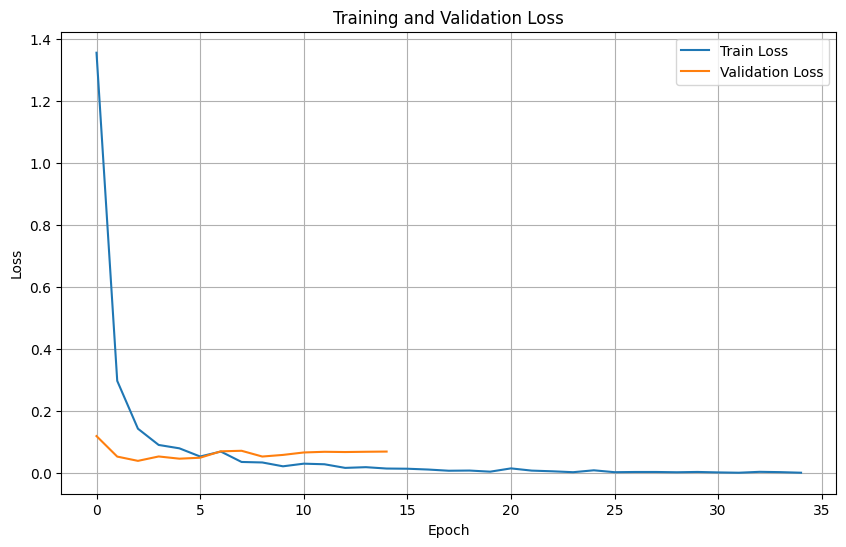

In [ ]:
import matplotlib.pyplot as plt

# Access the training logs from the trainer object
logs = trainer.state.log_history

# Extract training and validation loss
train_loss = [x["loss"] for x in logs if "loss" in x]
val_loss = [x["eval_loss"] for x in logs if "eval_loss" in x]

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()

**Evaluation**

In [ ]:
print("Running test evaluation…")

test_results = trainer.evaluate(test_ds)

print("=== TEST METRICS ===")
for k, v in test_results.items():
    print(f"{k}: {v}")



Running test evaluation…


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


=== TEST METRICS ===
eval_loss: 0.06658018380403519
eval_precision: 0.9505511811023623
eval_recall: 0.9593134138588684
eval_f1: 0.9549121974371143
eval_runtime: 231.473
eval_samples_per_second: 0.341
eval_steps_per_second: 0.173
epoch: 15.0


In [ ]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

model = trainer.model
model.eval()

all_preds = []
all_trues = []

test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=4, shuffle=False
)

for batch in test_loader:
    batch = {k: v.to(model.device) for k, v in batch.items()}

    with torch.no_grad():
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            bbox=batch["bbox"],
            pixel_values=batch["pixel_values"]
        )

    preds = outputs.logits.argmax(-1).cpu().numpy()
    labels = batch["labels"].cpu().numpy()

    for p, l in zip(preds, labels):
        mask = l != -100
        all_preds.extend(p[mask])
        all_trues.extend(l[mask])

precision = precision_score(all_trues, all_preds, average="macro")
recall = recall_score(all_trues, all_preds, average="macro")
f1 = f1_score(all_trues, all_preds, average="macro")

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)



=== DETAILED TOKEN METRICS ===
Precision: 0.9590104357080188
Recall: 0.9260928640661653
F1: 0.9397159532736452


<Figure size 1000x800 with 0 Axes>

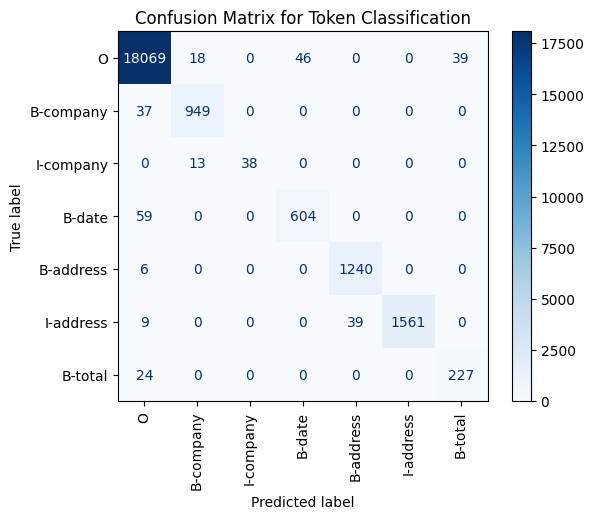


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     18172
   B-company       0.97      0.96      0.97       986
   I-company       1.00      0.75      0.85        51
      B-date       0.93      0.91      0.92       663
   B-address       0.97      1.00      0.98      1246
   I-address       1.00      0.97      0.98      1609
     B-total       0.85      0.90      0.88       251

    accuracy                           0.99     22978
   macro avg       0.96      0.93      0.94     22978
weighted avg       0.99      0.99      0.99     22978



In [ ]:
# Confusion matrix and classification report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

unique_labels = sorted(list(set(all_trues + all_preds)))

# Generate the confusion matrix
cm = confusion_matrix(all_trues, all_preds, labels=unique_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[id2label[l] for l in unique_labels])
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix for Token Classification')
plt.show()

# Generate and print the classification report
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(all_trues, all_preds, target_names=[id2label[l] for l in unique_labels], zero_division=0))

Extract SROIE fields + Compute BLEU AND ROUGE

In [ ]:
import torch
from tqdm import tqdm

model.eval()
pred_fields = []
true_fields = []

label2id = {l: i for i, l in enumerate(LABEL_LIST)}
id2label = {i: l for l, i in label2id.items()}

def decode_labels(input_ids, labels, predictions):
    tokens = processor.tokenizer.convert_ids_to_tokens(input_ids)
    pred_tags = [id2label[p] for p in predictions]
    true_tags = [id2label[l] if l != -100 else "O" for l in labels]

    # reconstruct text per-field
    def extract_field(tags, tokens, field):
        words = []
        for t, tok in zip(tags, tokens):
            if t == f"B-{field}" or t == f"I-{field}":
                words.append(tok.replace("##", ""))
        return " ".join(words)

    fields = [f.lower() for f in FIELDS]

    pred_dict = {f: extract_field(pred_tags, tokens, f) for f in fields}
    true_dict = {f: extract_field(true_tags, tokens, f) for f in fields}

    return pred_dict, true_dict


for batch in tqdm(test_loader):
    with torch.no_grad():
        outputs = model(
            pixel_values=batch["pixel_values"].to(model.device),
            input_ids=batch["input_ids"].to(model.device),
            attention_mask=batch["attention_mask"].to(model.device),
            bbox=batch["bbox"].to(model.device),
        )

    logits = outputs.logits.argmax(dim=-1).cpu().numpy()
    labels = batch["labels"].numpy()
    input_ids = batch["input_ids"].numpy()

    for i in range(len(input_ids)):
        pred, true = decode_labels(input_ids[i], labels[i], logits[i])
        pred_fields.append(pred)
        true_fields.append(true)

print(" Extracted predictions for BLEU/ROUGE evaluation")

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 20/20 [00:36<00:00,  1.84s/it]

 Extracted predictions for BLEU/ROUGE evaluation


In [ ]:
import re
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

smooth = SmoothingFunction().method1
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def normalize(text):
    if text is None:
        return ""
    text = text.lower()
    text = text.replace("##", "")
    text = text.replace("Ġ", "")
    text = re.sub(r"\s+", " ", text).strip()
    return text

bleu_scores = []
rouge_scores = []

fields = ["company", "address", "date", "total"]

for pred, true in zip(pred_fields, true_fields):
    for f in fields:
        p = normalize(pred[f])
        t = normalize(true[f])

        if t == "":
            continue

        # Calculate BLEU
        bleu = sentence_bleu([t.split()], p.split(), smoothing_function=smooth)
        bleu_scores.append(bleu)

        # Calculate ROUGE-L
        rouge = scorer.score(t, p)["rougeL"].fmeasure
        rouge_scores.append(rouge)

print("=== NORMALIZED BLEU & ROUGE-L (Field-level) ===")
print("BLEU:", sum(bleu_scores)/len(bleu_scores))
print("ROUGE-L:", sum(rouge_scores)/len(rouge_scores))

=== NORMALIZED BLEU & ROUGE-L (Field-level) ===
BLEU: 0.7050999151009781
ROUGE-L: 0.7978850609538164


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=401eaa0e36c7e6bd9a8871ed59aa95f00c77767e5b86cc4e647289f7a8d80f9b
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


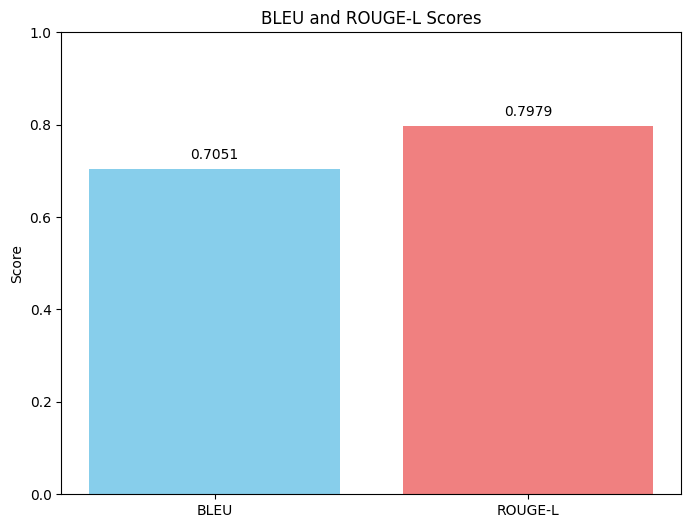

In [ ]:
import matplotlib.pyplot as plt

metrics = ['BLEU', 'ROUGE-L']
scores = [0.7050999151009781, 0.7978850609538164]

plt.figure(figsize=(8, 6))
plt.bar(metrics, scores, color=['skyblue', 'lightcoral'])
plt.ylim(0, 1)  # Scores are between 0 and 1
plt.ylabel('Score')
plt.title('BLEU and ROUGE-L Scores')

for i, score in enumerate(scores):
    plt.text(i, score + 0.02, f'{score:.4f}', ha='center')

plt.show()

# **Transfer Learning**

Creating Kenyan Receipts

In [ ]:
!pip install -q faker numpy pillow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.7 MB/s eta 0:00:00


In [ ]:
import random
from pathlib import Path
import json
import math
import numpy as np
from faker import Faker
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageOps
import matplotlib.pyplot as plt


In [ ]:
# Configurations
OUTDIR = Path("/content/kenyan_layoutlmv3_synth")
IMAGES_DIR = OUTDIR / "images"
ANNOT_DIR  = OUTDIR / "annotations"
IMAGES_DIR.mkdir(parents=True, exist_ok=True)
ANNOT_DIR.mkdir(parents=True, exist_ok=True)

NUM_SAMPLES = 1000
IMG_SIZES = [(600, 1000), (720, 1024), (768, 1100)]
FONT_PATHS = [
    "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf",
    "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf",
]
FALLBACK_FONT = None

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
fake = Faker("en_KE")
Faker.seed(SEED)

# Fields and BIO labels
FIELDS = ["company","date","address","total"]
LABEL_LIST = ["O"] + [f"{pfx}-{fld}" for fld in FIELDS for pfx in ("B","I")]
label2id = {lbl:i for i,lbl in enumerate(LABEL_LIST)}
id2label = {i:l for l,i in label2id.items()}

# Visual settings
DEFAULT_FONT_SIZE = 18


Data Preparation and Finetuning

In [ ]:
# Draw tokens, Normalize boxes, Noise & Effects, BIO label Assignment

def load_font(size):
    "Try known fonts, fallback to PIL default."
    for p in FONT_PATHS:
        try:
            return ImageFont.truetype(p, size)
        except Exception:
            continue
    return ImageFont.load_default()

def draw_token_and_bbox(draw, x, y, token, font, img_w, img_h):
    """
    Draw token at (x,y) with PIL and return pixel bbox (x0,y0,x1,y1).
    We use draw.textbbox for accurate bbox.
    """
    draw.text((x, y), token, font=font, fill=(0,0,0))
    x0, y0, x1, y1 = draw.textbbox((x, y), token, font=font)
    # clamp
    x0 = max(0, min(x0, img_w-1))
    x1 = max(0, min(x1, img_w-1))
    y0 = max(0, min(y0, img_h-1))
    y1 = max(0, min(y1, img_h-1))
    return [int(x0), int(y0), int(x1), int(y1)]

def px_to_layoutlm_box(px_box, img_w, img_h):
    "Convert pixel box to 0..1000 normalized box (LayoutLMv3 style)"
    x0, y0, x1, y1 = px_box
    return [
        int((x0 / img_w) * 1000),
        int((y0 / img_h) * 1000),
        int((x1 / img_w) * 1000),
        int((y1 / img_h) * 1000),
    ]

def add_paper_background(img, paper_color=(250,250,245)):
    "Place receipt on paper-like background, with subtle shadow."
    pad = 20
    W, H = img.size
    bg = Image.new("RGB", (W + pad*2, H + pad*2), paper_color)
    # paste with shadow
    shadow = Image.new("RGBA", img.size, (0,0,0,0))
    bg.paste(img, (pad, pad))
    return bg

def add_noise_and_artifacts(img, severity=0.4):
    "Add mild noise, blur, and brightness variation to mimic printer/phone capture."
    arr = np.array(img).astype(np.int16)
    # gaussian noise
    noise_amp = int(6 * severity)
    noise = np.random.normal(0, noise_amp, arr.shape).astype(np.int16)
    arr = arr + noise
    arr = np.clip(arr, 0, 255).astype(np.uint8)
    out = Image.fromarray(arr)
    # slight blur occasionally
    if random.random() < 0.3:
        out = out.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.2, 1.2)*severity*2))
    # slight contrast jitter
    if random.random() < 0.5:
        enhancer = ImageOps.autocontrast(out, cutoff=int(2*severity))
        out = enhancer
    return out

def find_best_span_on_tokens(tokens, query):
    """Brute-force approximate span matching; returns (start,end,score)."""
    best = (0,0,0.0)
    qlower = query.lower().strip()
    for i in range(len(tokens)):
        running = []
        for j in range(i, len(tokens)):
            running.append(tokens[j])
            s = " ".join(running)
            ratio = SequenceMatcher(None, s.lower(), qlower).ratio()
            if ratio > best[2]:
                best = (i, j+1, ratio)
            if len(s) > len(query)*3 + 40:
                break
    return best

from difflib import SequenceMatcher

def assign_bio_labels(words, fields):
    """
    Assign BIO labels per token for fields dict {company,date,address,total}.
    Uses fuzzy matching to map multi-token spans.
    """
    labels = ["O"] * len(words)
    for f in FIELDS:
        query = str(fields.get(f,"")).strip()
        if not query:
            continue
        start, end, score = find_best_span_on_tokens(words, query)
        # fallback heuristics for numeric totals/dates
        if score < 0.3:
            if f == "total":
                # try exact numeric match token
                qnum = "".join(ch for ch in query if ch.isdigit() or ch in ".,")
                for idx, tk in enumerate(words):
                    if qnum and qnum in tk:
                        start, end, score = idx, idx+1, 1.0
                        break
            if f == "date":
                # date pattern
                import re
                m = re.search(r"\d{1,2}[/-]\d{1,2}[/-]\d{2,4}", query)
                if m:
                    qd = m.group(0)
                    for idx, tk in enumerate(words):
                        if qd in tk:
                            start, end, score = idx, idx+1, 1.0
                            break
        if score >= 0.3 and end > start:
            labels[start] = f"B-{f}"
            for k in range(start+1, end):
                labels[k] = f"I-{f}"
    return labels


In [ ]:
# Template Generator

def place_text_lines_and_tokens(draw, start_y, lines, font, img_w, img_h,
                                margin_x=36, spacing=8, align="left"):
    """
    Draw lines (list of strings). Returns words, normalized boxes and end y.
    align: 'left', 'center', or 'right' (per-line).
    """
    y = start_y
    words = []
    boxes = []

    for line in lines:
        # optional two-column items (if '::' present in the line, treat left::right)
        if "::" in line:
            left, right = line.split("::", 1)
            left = left.strip(); right = right.strip()
            # draw left at margin_x, right right-aligned
            x_left = margin_x
            x_right_start = img_w - margin_x
            # right token width measured with font
            # draw left tokens
            left_tokens = left.split()
            x = x_left
            for tk in left_tokens:
                b = draw_token_and_bbox(draw, x, y, tk, font, img_w, img_h)
                words.append(tk); boxes.append(b)
                # advance
                x = b[2] + draw.textbbox((0,0)," ",font=font)[2] - draw.textbbox((0,0)," ",font=font)[0]

            # draw right tokens right-aligned from x_right_start
            right_tokens = right.split()
            # compute total width
            widths = [draw.textbbox((0,0),tk,font=font)[2] - draw.textbbox((0,0),tk,font=font)[0] for tk in right_tokens]
            total_w = sum(widths) + (len(widths)-1) * (draw.textbbox((0,0)," ",font=font)[2])
            rx = x_right_start - total_w
            for tk in right_tokens:
                b = draw_token_and_bbox(draw, rx, y, tk, font, img_w, img_h)
                words.append(tk); boxes.append(b)
                rx = b[2] + draw.textbbox((0,0)," ",font=font)[2]
            # line advance
            y += (boxes[-1][3] - boxes[-1][1]) + spacing
            continue

        # otherwise single-column line -> handle alignment
        tokens = line.split()
        if not tokens:
            y += spacing * 2
            continue

        # compute starting x by alignment
        if align == "center":
            line_w = sum((draw.textbbox((0,0),tk,font=font)[2] - draw.textbbox((0,0),tk,font=font)[0] for tk in tokens)) \
                    + (len(tokens)-1) * draw.textbbox((0,0)," ",font=font)[2]
            x = max(margin_x, (img_w - line_w) // 2)
        elif align == "right":
            line_w = sum((draw.textbbox((0,0),tk,font=font)[2] - draw.textbbox((0,0),tk,font=font)[0] for tk in tokens)) \
                    + (len(tokens)-1) * draw.textbbox((0,0)," ",font=font)[2]
            x = img_w - margin_x - line_w
        else:
            x = margin_x

        for tk in tokens:
            b = draw_token_and_bbox(draw, x, y, tk, font, img_w, img_h)
            words.append(tk); boxes.append(b)
            # advance
            x = b[2] + draw.textbbox((0,0)," ",font=font)[2]
        # next line
        y += (boxes[-1][3] - boxes[-1][1]) + spacing

    # normalize boxes for layoutlmv3 (0..1000)
    nb = [px_to_layoutlm_box(b, img_w, img_h) for b in boxes]
    return words, nb, y

def generate_receipt_image(idx, template_variant=0):
    """
    Create a single realistic receipt according to variant.
    Returns ann dict with image_path, words, bboxes, labels, fields.
    """
    # choose size & font
    img_w, img_h = random.choice(IMG_SIZES)
    img = Image.new("RGB", (img_w, img_h), (255,255,255))
    draw = ImageDraw.Draw(img)
    # Random font sizes (header vs body)
    header_font = load_font(DEFAULT_FONT_SIZE + random.randint(4,10))
    body_font = load_font(DEFAULT_FONT_SIZE + random.randint(-2,4))
    small_font = load_font(max(12, DEFAULT_FONT_SIZE-4))

    # Field values (realistic)
    company = random.choice([
        fake.company().upper(),
        "NAIVAS SUPERMARKET",
        "TUSKYS SUPERMARKET",
        "NAKUMATT SUPERMARKET",
        "QUICKMART"
    ])
    date_dt = fake.date_between(start_date="-2y", end_date="today")
    date = date_dt.strftime("%d/%m/%Y")
    address = fake.address().replace("\n", ", ")
    total_val = 0.0

    lines = []
    y_cursor = 20 + random.randint(0, 10)

    # Header (center)
    header_lines = [company]
    words_h, boxes_h, y_cursor = place_text_lines_and_tokens(draw, y_cursor, header_lines, header_font, img_w, img_h, margin_x=30, spacing=6, align="center")

    # small meta
    meta_lines = [address]
    words_m, boxes_m, y_cursor = place_text_lines_and_tokens(draw, y_cursor+6, meta_lines, small_font, img_w, img_h, margin_x=30, spacing=6, align="center")

    # Separator
    sep_y = y_cursor + 6
    draw.line((30, sep_y, img_w-30, sep_y), fill=(0,0,0), width=1)
    y_cursor = sep_y + 8

    # Items: create 3-12 rows with left (name) and right (price)
    num_items = random.randint(3, 10)
    items = []
    for _ in range(num_items):
        item_name = fake.word().upper() + ("" if random.random() < 0.6 else " " + fake.word().upper())
        price = round(random.uniform(10.0, 2000.0), 2)
        items.append((item_name, price))

    # Place items (use :: to indicate left::right in place_text...)
    item_lines = [f"{n} :: {p:,.2f}" for n,p in items]
    words_i, boxes_i, y_cursor = place_text_lines_and_tokens(draw, y_cursor, item_lines, body_font, img_w, img_h, margin_x=36, spacing=6, align="left")

    # compute subtotal and VAT
    subtotal = sum(p for _,p in items)
    vat = subtotal * 0.16 if random.random() < 0.7 else subtotal * 0.125
    total = subtotal + vat
    total_val = round(total, 2)

    # place subtotal/vat/total aligned right (each a line)
    right_lines = [f"SUBTOTAL :: {subtotal:,.2f}", f"VAT :: {vat:,.2f}", f"TOTAL :: {total_val:,.2f}"]
    words_r, boxes_r, y_cursor = place_text_lines_and_tokens(draw, y_cursor+6, right_lines, body_font, img_w, img_h, margin_x=36, spacing=6, align="left")

    # footer: payment method + thanks
    payment = random.choice(["CASH", "CARD", "M-PESA", "VISA"])
    footer_lines = [f"Payment :: {payment}", "THANK YOU FOR SHOPPING WITH US!"]
    words_f, boxes_f, y_cursor = place_text_lines_and_tokens(draw, y_cursor+10, footer_lines, small_font, img_w, img_h, margin_x=36, spacing=6, align="center")

    # small random rotation / warp (mild)
    if random.random() < 0.25:
        img = img.rotate(random.uniform(-1.2,1.2), resample=Image.BICUBIC, expand=False, fillcolor=(255,255,255))
        draw = ImageDraw.Draw(img)

    # noise/artifacts
    img = add_noise_and_artifacts(img, severity=random.uniform(0.2,0.6))

    page = add_paper_background(img)

    # final small compression artifacts — re-save with JPEG if needed
    image_path = IMAGES_DIR / f"receipt_{idx:06d}.jpg"
    page.save(image_path, quality=88)

    # Combine words & boxes from all parts in draw order:
    all_words = words_h + words_m + words_i + words_r + words_f
    all_boxes  = boxes_h + boxes_m + boxes_i + boxes_r + boxes_f

    # assign BIO labels using fields
    fields = {"company": company, "date": date, "address": address, "total": f"{total_val:.2f}"}
    labels = assign_bio_labels(all_words, fields)

    # Save annotation with normalized 0..1000 boxes
    ann = {
        "image_path": str(image_path),
        "words": all_words,
        "bboxes": all_boxes,
        "labels": labels,
        "fields": fields
    }
    json_path = ANNOT_DIR / f"receipt_{idx:06d}.json"
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(ann, f, ensure_ascii=False, indent=2)

    return ann


In [ ]:
# Generate dataset
from tqdm.auto import tqdm

all_annotations = []
for i in tqdm(range(NUM_SAMPLES), desc="Generating receipts"):
    ann = generate_receipt_image(i)
    all_annotations.append(ann)

# Save summary metadata
meta_path = OUTDIR / "dataset_metadata.json"
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump({"num_samples": NUM_SAMPLES, "annotations": [a["image_path"] for a in all_annotations]}, f, indent=2)

print("DONE! Generated:", NUM_SAMPLES)
print("Images:", IMAGES_DIR)
print("Annotations:", ANNOT_DIR)


Generating receipts:   0%|          | 0/1000 [00:00<?, ?it/s]

DONE! Generated: 1000
Images: /content/kenyan_layoutlmv3_synth/images
Annotations: /content/kenyan_layoutlmv3_synth/annotations


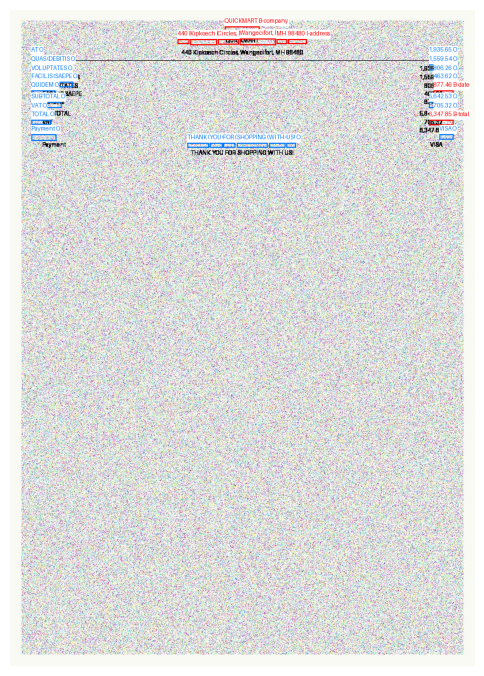

FIELDS: {'company': 'QUICKMART', 'date': '07/07/2024', 'address': '440 Kipkoech Circles, Wangecifort, MH 98480', 'total': '6347.85'}


In [ ]:
# Visualize random sample
import random
from PIL import Image, ImageDraw, ImageFont
def denormalize_bbox(bbox, w, h):
    x0, y0, x1, y1 = bbox
    return (int(x0/1000 * w), int(y0/1000 * h), int(x1/1000 * w), int(y1/1000 * h))

ann_files = list(ANNOT_DIR.glob("*.json"))
sample = json.load(open(random.choice(ann_files), "r", encoding="utf-8"))
img = Image.open(sample["image_path"]).convert("RGB")
w,h = img.size
draw = ImageDraw.Draw(img)
try:
    vis_font = ImageFont.truetype(FONT_PATHS[0], 14)
except:
    vis_font = ImageFont.load_default()

for word, box, lbl in zip(sample["words"], sample["bboxes"], sample["labels"]):
    x0,y0,x1,y1 = denormalize_bbox(box,w,h)
    color = (255,0,0) if lbl != "O" else (0,120,255)
    draw.rectangle([x0,y0,x1,y1], outline=color, width=2)
    text = f"{word} {lbl}"
    draw.rectangle([x0, max(0,y0-16), x0+draw.textbbox((0,0),text,font=vis_font)[2], max(0,y0-1)], fill=(255,255,255))
    draw.text((x0, max(0,y0-16)), text, fill=color, font=vis_font)

plt.figure(figsize=(6,12))
plt.imshow(img); plt.axis("off")
plt.show()

# Print ground-truth fields
print("FIELDS:", sample["fields"])


Training

In [ ]:
!pip install transformers datasets seqeval accelerate pillow


In [ ]:
# Label list
LABEL_LIST = [
    "O",
    "B-company", "I-company",
    "B-date", "I-date",
    "B-address", "I-address",
    "B-total", "I-total",
]

label2id = {l:i for i,l in enumerate(LABEL_LIST)}
id2label = {i:l for l,i in label2id.items()}
NUM_LABELS = len(LABEL_LIST)



In [ ]:
from pathlib import Path
import json
from datasets import Dataset

ANN_DIR = Path("/content/kenyan_layoutlmv3_synth/annotations")
IMG_DIR = Path("/content/kenyan_layoutlmv3_synth/images")

samples = []

for ann_file in ANN_DIR.glob("*.json"):
    with open(ann_file, "r") as f:
        ann = json.load(f)

    samples.append({
        "image_path": ann["image_path"],
        "words": ann["words"],
        "bboxes": ann["bboxes"],
        "labels": ann["labels"]
    })

dataset = Dataset.from_list(samples)


In [ ]:
train_test = dataset.train_test_split(test_size=0.2, seed=42)
val_test  = train_test["test"].train_test_split(test_size=0.5, seed=42)

train_ds = train_test["train"]
val_ds   = val_test["train"]
test_ds  = val_test["test"]

train_ds, val_ds, test_ds


(Dataset({
     features: ['image_path', 'words', 'bboxes', 'labels'],
     num_rows: 800
 }),
 Dataset({
     features: ['image_path', 'words', 'bboxes', 'labels'],
     num_rows: 100
 }),
 Dataset({
     features: ['image_path', 'words', 'bboxes', 'labels'],
     num_rows: 100
 }))

In [ ]:
from transformers import LayoutLMv3Processor
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

In [ ]:
from PIL import Image

def encode_batch(batch):
    images, words, boxes, encoded_labels = [], [], [], []

    for img_path, w, b, l in zip(batch["image_path"], batch["words"], batch["bboxes"], batch["labels"]):
        images.append(Image.open(img_path).convert("RGB"))
        words.append(w)
        boxes.append(b)
        encoded_labels.append([label2id[x] for x in l])

    return processor(
        images=images,
        text=words,
        boxes=boxes,
        word_labels=encoded_labels,
        padding="max_length",
        truncation=True,
        max_length=512,
    )
train_ds = train_ds.map(encode_batch, batched=True, remove_columns=train_ds.column_names)
val_ds   = val_ds.map(encode_batch,   batched=True, remove_columns=val_ds.column_names)
test_ds  = test_ds.map(encode_batch,  batched=True, remove_columns=test_ds.column_names)


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
!pip install seqeval


In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
import numpy as np

label_list = LABEL_LIST

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)

    true_labels = [
        [label_list[l] for l, p in zip(label_row, pred_row) if l != -100]
        for label_row, pred_row in zip(labels, predictions)
    ]

    true_predictions = [
        [label_list[p] for l, p in zip(label_row, pred_row) if l != -100]
        for label_row, pred_row in zip(labels, predictions)
    ]

    return {
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions),
    }


In [ ]:
import os
from transformers import TrainingArguments, Trainer

# Disable Weights & Biases logging
os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments(
    output_dir="/content/layoutlmv3_receipt_model",
    num_train_epochs=10,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=5e-5,
    weight_decay=0.01,

    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,

    logging_steps=50,
    fp16=True,
    push_to_hub=False,
    report_to="none",
)
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=processor.tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2058566410.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.066800,0.059913,1.000000,0.810811,0.895522
2,0.061400,0.055738,1.000000,0.810811,0.895522
3,0.053300,0.058639,0.993421,0.816216,0.896142
4,0.050600,0.050832,0.950920,0.837838,0.890805
5,0.047600,0.052066,0.993421,0.816216,0.896142
6,0.039300,0.055087,0.883784,0.883784,0.883784
7,0.036600,0.061688,0.920455,0.875676,0.897507
8,0.032600,0.066065,0.931548,0.845946,0.886686
9,0.026200,0.070523,0.893557,0.862162,0.877579
10,0.019700,0.077124,0.891667,0.867568,0.879452


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/modelin

TrainOutput(global_step=1000, training_loss=0.05270730572938919, metrics={'train_runtime': 1850.9196, 'train_samples_per_second': 4.322, 'train_steps_per_second': 0.54, 'total_flos': 2108880543744000.0, 'train_loss': 0.05270730572938919, 'epoch': 10.0})

In [ ]:
processor.save_pretrained("/content/layoutlmv3_receipt_model")
model.save_pretrained("/content/layoutlmv3_receipt_model")

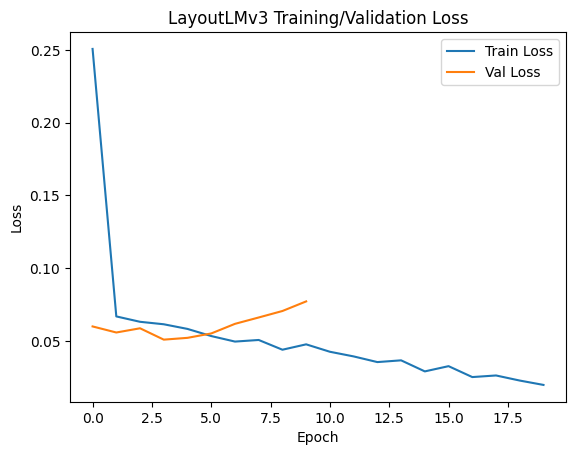

In [ ]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

train_loss = [x["loss"] for x in logs if "loss" in x]
val_loss   = [x["eval_loss"] for x in logs if "eval_loss" in x]

plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LayoutLMv3 Training/Validation Loss")
plt.show()


In [ ]:
from seqeval.metrics import classification_report
import numpy as np

# Get label list using the global LABEL_LIST variable
label_list = LABEL_LIST

def get_predictions_and_labels(trainer, dataset):
    """Runs the model on a dataset and returns predicted + true label strings."""
    preds_output = trainer.predict(dataset)
    predictions = np.argmax(preds_output.predictions, axis=-1)
    labels = preds_output.label_ids

    true_predictions = []
    true_labels = []

    for pred_row, label_row in zip(predictions, labels):
        pred_tags = []
        label_tags = []
        for p, l in zip(pred_row, label_row):
            if l == -100:  # ignore special tokens
                continue
            pred_tags.append(label_list[p])
            label_tags.append(label_list[l])

        true_predictions.append(pred_tags)
        true_labels.append(label_tags)

    return true_predictions, true_labels

preds, labels = get_predictions_and_labels(trainer, val_ds)

print(classification_report(labels, preds))

/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


              precision    recall  f1-score   support

     address       1.00      1.00      1.00       100
     company       1.00      1.00      1.00       100
        date       0.38      0.14      0.21        70
       total       1.00      1.00      1.00       100

   micro avg       0.95      0.84      0.89       370
   macro avg       0.85      0.79      0.80       370
weighted avg       0.88      0.84      0.85       370

